# Salary Prediction Code

## Imports

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import pickle
import zipfile


# Visualization
import matplotlib.pyplot as plt

# Scikit-Learn Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Scikit-Learn Utilities
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Scikit-Learn Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Functions

In [2]:
# Simplifica la impresión de los números
def format_number(num):
    if num >= 1_000_000:
        return f"{num / 1_000_000:.1f}M"
    elif num >= 1_000:
        return f"{num / 1_000:.1f}K"
    else:
        return str(num)

# Nos ayuda a deshacernos de aquellos países con pocos datos
def cut_cat(category_data, threshold):
    category_mapping = {}
    for idx in range(len(category_data)):
        if category_data.values[idx] >= threshold:
            category_mapping[category_data.index[idx]] = category_data.index[idx]
        else:  # if insufficient data, categorize as "Other"
            category_mapping[category_data.index[idx]] = 'Other'
    return category_mapping

# Simplifica las strings
def short_ed(x):
    if 'Bachelor’s degree' in x:
        return 'Bachelor’s degree'
    if 'Master’s degree' in x:
        return 'Master’s degree'
    if 'Professional degree' in x or 'Other doctoral' in x:
        return 'Post grad'
    return 'Less than a Bachelors'

## Reading Dataset

In [3]:
#df = pd.read_csv("survey_results_public.csv")

with zipfile.ZipFile("data.zip") as z:
    with z.open("survey_results_public.csv") as f:
        df = pd.read_csv(f)

df.head()

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN
3,4,I am learning to code,18-24 years old,"Student, full-time",NaN,Apples,NaN,Some college/university study without earning ...,"Other online resources (e.g., videos, blogs, f...",Stack Overflow;How-to videos;Interactive tutorial,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN,NaN
4,5,I am a developer by profession,18-24 years old,"Student, full-time",NaN,Apples,NaN,"Secondary school (e.g. American high school, G...","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too short,Easy,NaN,NaN


We want to keep the independet variables that will help us train our model.

In [4]:
keep = ["Country", "EdLevel", "YearsCodePro", "Employment", "ConvertedCompYearly"]
df = df[keep]
df = df.rename({"ConvertedCompYearly": "Salary"}, axis=1)
df.head()

,Country,EdLevel,YearsCodePro,Employment,Salary
0,United States of America,Primary/elementary school,NaN,"Employed, full-time",NaN
1,United Kingdom of Great Britain and Northern I...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",17,"Employed, full-time",NaN
2,United Kingdom of Great Britain and Northern I...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",27,"Employed, full-time",NaN
3,Canada,Some college/university study without earning ...,NaN,"Student, full-time",NaN
4,Norway,"Secondary school (e.g. American high school, G...",NaN,"Student, full-time",NaN


## Data cleaning

We will delete those rows where the salary was not input.

In [5]:
df = df.dropna(subset=['Salary'])
df.head()

,Country,EdLevel,YearsCodePro,Employment,Salary
72,Pakistan,"Secondary school (e.g. American high school, G...",1,"Employed, full-time;Student, full-time;Indepen...",7322.0
374,Austria,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",6,"Employed, full-time",30074.0
379,Turkey,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",6,"Employed, full-time",91295.0
385,France,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",17,"Independent contractor, freelancer, or self-em...",53703.0
389,United States of America,Some college/university study without earning ...,7,"Employed, full-time;Student, part-time",110000.0


In [6]:
df.isnull().sum()

Country          0
EdLevel          0
YearsCodePro    90
Employment       0
Salary           0
dtype: int64

We still need to get rid of some rows that are missing values.

Another approach is to fill in those missing values with the mean of the values.

In [7]:
df = df.dropna()
df.isnull().sum()

Country         0
EdLevel         0
YearsCodePro    0
Employment      0
Salary          0
dtype: int64

We are just going to work with those **full-time** employees.

In [8]:
df = df[df["Employment"].str.contains("full-time", case=False, na=False)]

df = df.drop("Employment", axis=1) # we don't need thise column for the prediction
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20730 entries, 72 to 41187
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       20730 non-null  object 
 1   EdLevel       20730 non-null  object 
 2   YearsCodePro  20730 non-null  object 
 3   Salary        20730 non-null  float64
dtypes: float64(1), object(3)
memory usage: 809.8+ KB


For some of the countries we only have 1 data point, which is irrelevant.

In [9]:
df['Country'].value_counts()

Country
United States of America                                4397
Germany                                                 1757
Ukraine                                                 1345
United Kingdom of Great Britain and Northern Ireland    1246
India                                                    943
                                                        ... 
Lesotho                                                    1
Burundi                                                    1
Barbados                                                   1
Mali                                                       1
Congo, Republic of the...                                  1
Name: count, Length: 160, dtype: int64

In [10]:
country_map = cut_cat(df.Country.value_counts(), 400)

In [11]:
df['Country'] = df['Country'].map(country_map)
df.Country.value_counts()

Country
Other                                                   6113
United States of America                                4397
Germany                                                 1757
Ukraine                                                 1345
United Kingdom of Great Britain and Northern Ireland    1246
India                                                    943
France                                                   789
Canada                                                   788
Brazil                                                   604
Spain                                                    501
Poland                                                   467
Italy                                                    466
Netherlands                                              456
Australia                                                451
Sweden                                                   407
Name: count, dtype: int64

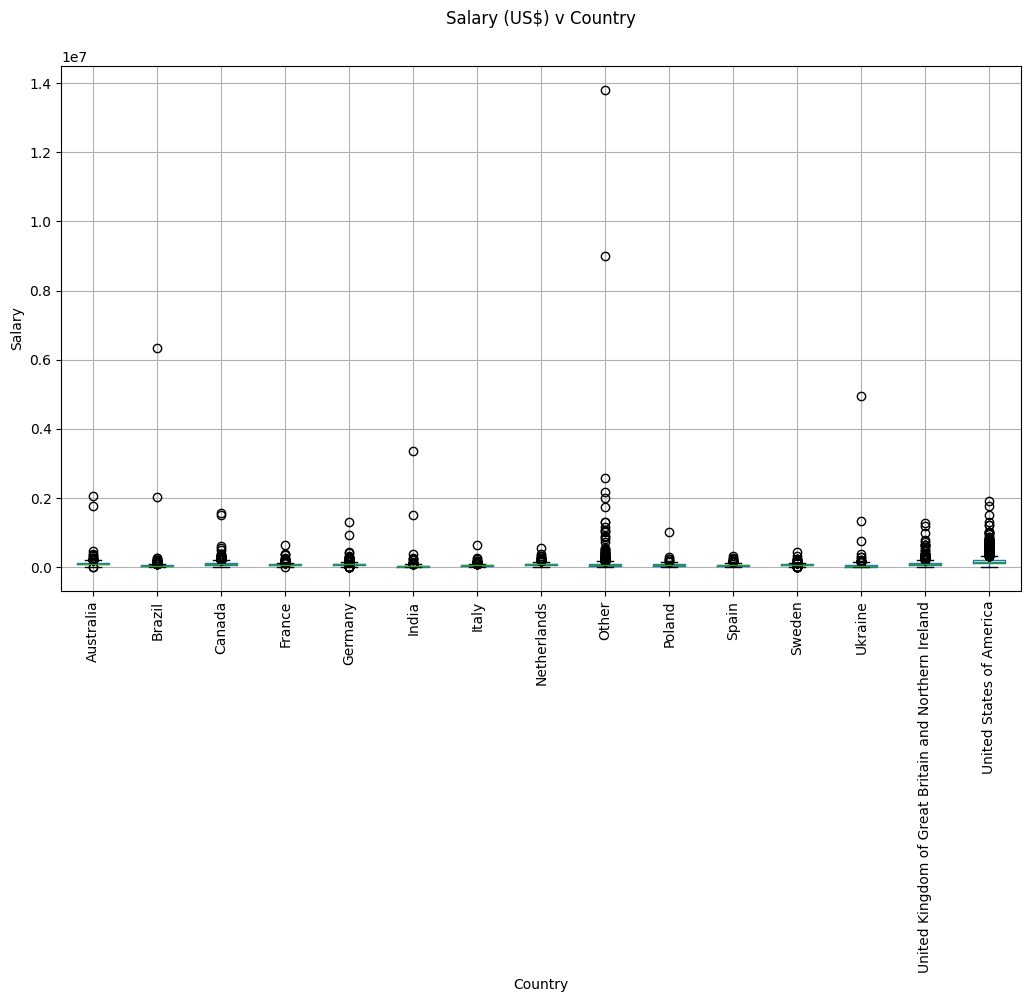

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
df.boxplot('Salary', 'Country', ax=ax)
plt.suptitle('Salary (US$) v Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()

In [13]:
df = df[df["Salary"] <= 250000] # in our plot 0.2
df = df[df["Salary"] >= 10000]
df = df[df['Country'] != 'Other'] # we will not keep other

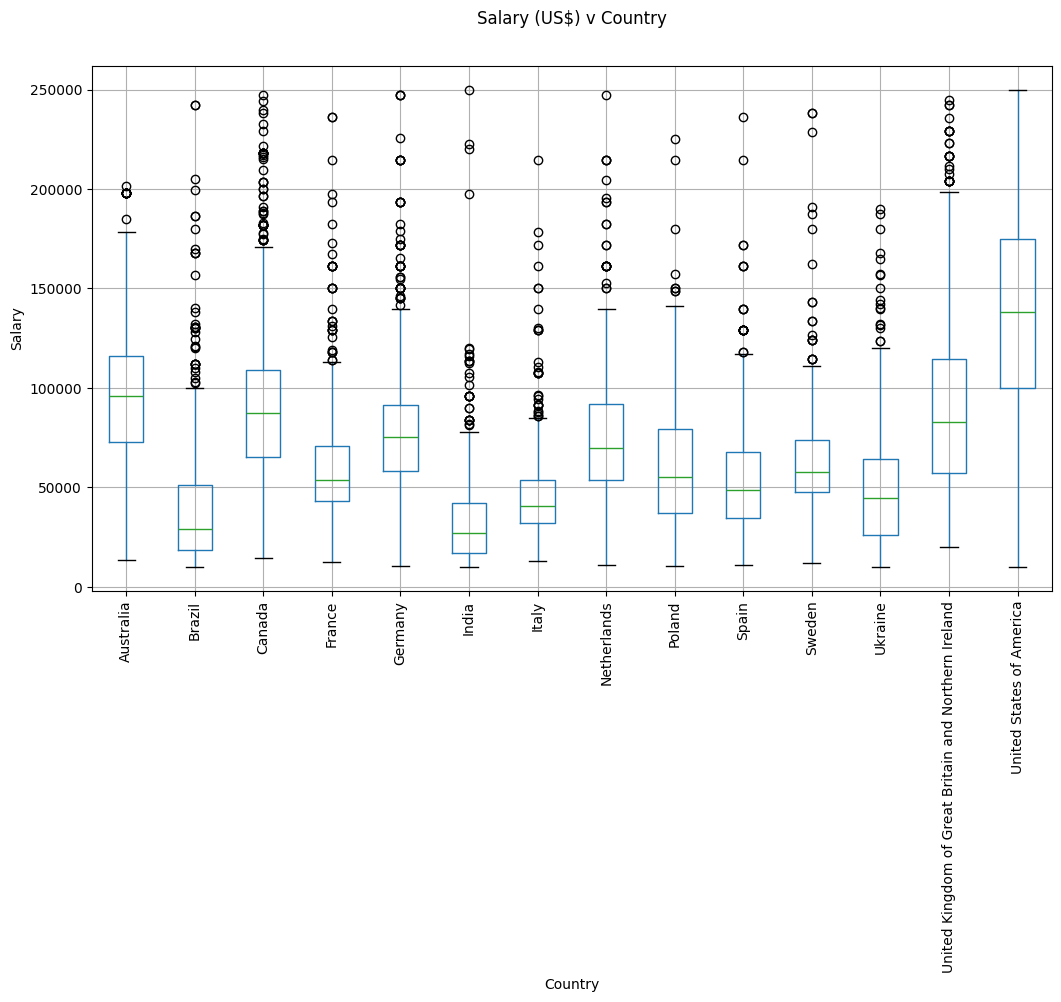

In [14]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
df.boxplot('Salary', 'Country', ax=ax)
plt.suptitle('Salary (US$) v Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()

In [15]:
df["YearsCodePro"].unique()

array(['7', '18', '25', '30', '50', '27', '17', '1', '15', '4', '11',
       '23', '10', '8', '12', '26', '40', '9', '22', '28', '20', '16',
       '13', '3', '35', '5', '31', '41', '36', '24', '6', '14',
       'Less than 1 year', '2', '38', '32', '21', '19', '34', '29', '43',
       '33', '45', '37', '44', '42', '39', '46', '49', '48', '47'],
      dtype=object)

In order to deal with numbers, we will get rid of those strings elements.

```python
if "string x":
    return X
else:
    return X
```

In [16]:
df['YearsCodePro'] = df['YearsCodePro'].apply(lambda x: 0.5 if x == 'Less than 1 year' else float(x))


We do the same thing with "EdLevel" column.

In [17]:
df["EdLevel"].unique()

array(['Some college/university study without earning a degree',
       'Professional degree (JD, MD, Ph.D, Ed.D, etc.)',
       'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Associate degree (A.A., A.S., etc.)', 'Primary/elementary school',
       'Something else'], dtype=object)

In [18]:
df['EdLevel'] = df['EdLevel'].apply(short_ed)

In [19]:
df["EdLevel"].unique()

array(['Less than a Bachelors', 'Post grad', 'Master’s degree',
       'Bachelor’s degree'], dtype=object)

#### STREAMLIT HELP

In [20]:
ed_tuple = tuple(df["EdLevel"].unique())

for ed in ed_tuple:
    print(ed)

Less than a Bachelors
Post grad
Master’s degree
Bachelor’s degree


In [21]:
country_tuple = tuple(df["Country"].unique())

for country in country_tuple:
    print(country)

United States of America
United Kingdom of Great Britain and Northern Ireland
France
Brazil
Germany
Ukraine
Canada
Italy
India
Spain
Netherlands
Sweden
Poland
Australia


## Transform data

Notice that we are dealing with strings & numbers, and computers understand binary code, therefore we will need to transform those strings columns to number.

In [22]:
le_ed = LabelEncoder()
df['EdLevel'] = le_ed.fit_transform(df['EdLevel'])
df["EdLevel"].unique()

array([1, 3, 2, 0])

In [23]:
le_country = LabelEncoder()
df['Country'] = le_country.fit_transform(df['Country'])
df["Country"].unique()

array([13, 12,  3,  1,  4, 11,  2,  6,  5,  9,  7, 10,  8,  0])

## Model Training

We need to split the model in features and the target.

In [24]:
X = df.drop("Salary", axis=1) #feature
y = df["Salary"] #target 

### Regression problem

We are not predidcting a defined category cat/dog, we are predicting numbers | Not classifying

In [25]:
linear_reg = LinearRegression()
linear_reg.fit(X, y.values)

LinearRegression()

In [26]:
y_pred = linear_reg.predict(X)

Noticed that our range is from 10K to 2.500K

In [27]:
error = np.sqrt(mean_squared_error(y, y_pred))
print(f"We are getting around -> ${format_number(error)}")

We are getting around -> $44.8K


### Decision Tree

In [28]:
dec_tree_reg = DecisionTreeRegressor(random_state=0)
dec_tree_reg.fit(X, y.values)

DecisionTreeRegressor(random_state=0)

In [29]:
y_pred = dec_tree_reg.predict(X)

In [30]:
error = np.sqrt(mean_squared_error(y, y_pred))
print(f"We are getting around -> ${format_number(error)}")

We are getting around -> $31.9K


### Random Forest

In [31]:
random_forest_reg = RandomForestRegressor(random_state=0)
random_forest_reg.fit(X, y.values)

RandomForestRegressor(random_state=0)

In [32]:
y_pred = random_forest_reg.predict(X)

In [33]:
error = np.sqrt(mean_squared_error(y, y_pred))
print(f"We are getting around -> ${format_number(error)}")

We are getting around -> $32.0K


**GRIDSEARCH**

We can use GridSearchCV to find the best parameters for our models

In [34]:
max_depth = [None, 2,4,6,8,10,12]
parameters = {"max_depth": max_depth}

regressor = DecisionTreeRegressor(random_state=0)
gs = GridSearchCV(regressor, parameters, scoring='neg_mean_squared_error')
gs.fit(X, y.values)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': [None, 2, 4, 6, 8, 10, 12]},
             scoring='neg_mean_squared_error')

After doing so, we are going to test it again.

In [35]:
regressor = gs.best_estimator_

regressor.fit(X, y.values)
y_pred = regressor.predict(X)
error = np.sqrt(mean_squared_error(y, y_pred))
print(f"We are getting around -> ${format_number(error)}")

We are getting around -> $33.9K


In [36]:
X

,Country,EdLevel,YearsCodePro
389,13,1,7.0
392,12,3,18.0
395,12,2,25.0
398,13,1,30.0
409,3,3,50.0
...,...,...,...
41179,11,1,6.0
41180,10,2,3.0
41184,13,2,30.0
41185,13,0,15.0


Imagine we are getting a new row with the following characteristics (yo)

In [37]:
# country, edlevel, yearscode
X = np.array([["Spain", 'Bachelor’s degree', 1 ]])
X

array([['Spain', 'Bachelor’s degree', '1']], dtype='<U21')

We apply the label enconder for contry & education level

In [38]:
X[:, 0] = le_country.transform(X[:,0])
X[:, 1] = le_ed.transform(X[:,1])
X = X.astype(float) #float aarray
X

array([[9., 0., 1.]])

In [39]:
y_pred = regressor.predict(X)
print(f"The predicted salary is ${format_number(y_pred[0])}")

The predicted salary is $38.7K


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


## Exporting our model

Saving model

In [40]:
data = {"model": regressor, "le_country": le_country, "le_education": le_ed}
with open('salary_pred_model.pkl', 'wb') as file:
    pickle.dump(data, file)

Open model

In [41]:
with open('salary_pred_model.pkl', 'rb') as file:
    data = pickle.load(file)

regressor_loaded = data["model"]
le_country = data["le_country"]
le_ed = data["le_education"]

Let's run the prediction with our loaded model. We should get the save value

In [42]:
y_pred2 = regressor_loaded.predict(X)
if y_pred == y_pred2:
    print("We are getting the same value.")
    print(f"${format_number(y_pred[0])}") # 38.8K
else:
    print("Different value this time.")
    print(f"The new predicted salary is ${format_number(y_pred2[0])}")

We are getting the same value.
$38.7K


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
